In [15]:
import torch
from torchvision import datasets, transforms

# transform images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download training and test dataset
train_dataset = datasets.MNIST(root='../data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data/', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.65MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 67.9kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 602kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.26MB/s]

Training samples: 60000, Test samples: 10000


## Import Libraries

In [2]:
import torch            # main PyTorch library
import torch.nn as nn   # neural network module
import torch.nn.functional as F     # functional interface
from torch.utils.data import DataLoader     # data loading utilities

## Set Hyperparameters

In [3]:
batch_size=64               # number of samples per batch
learning_rate = 0.01        # step size for optimizer
epochs = 3          # number of times the model sees the entire dataset

## Create Data Loaders

In [4]:
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)     # iterates over training data in batches
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle = False)       # iterates over test data in batches

## Define Neural Network

In [5]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):                   # defines how input moves through layers
        x = x.view(-1, 28*28)               # flatten 28x28 images to 784
        x = F.relu(self.fc1(x))             # activation function introducing non-linearity
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Initialize Model, Loss, Optimizer

In [6]:
model = SimpleNN()                     # instantiate the model
criterion = nn.CrossEntropyLoss()      # loss function measuring prediction error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimization algorithm


## Training Loop

In [7]:
for epoch in range(epochs):                 # loop over the dataset multiple times
    for images, labels in train_loader:         # iterate over batches
        outputs = model(images)      # forward pass, calculates predictions
        loss = criterion(outputs, labels)       # compute the loss
        optimizer.zero_grad()           # clear previous gradients
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # update model parameters
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")           # print loss after each epoch


Epoch [1/3], Loss: 0.0672
Epoch [2/3], Loss: 0.1778
Epoch [3/3], Loss: 0.1387


## Evaluate Accuracy

In [8]:
# Evaluate on test data
model.eval()  # set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # no need to calculate gradients
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 96.74%


In [14]:
torch.save(model.state_dict(), "/Users/ahmedsalimkidwai/aws-ml-pipeline/models/simple_mnist.pth")


In [24]:
import torch

# Make sure model is in evaluation mode
model.eval()

# Pick one batch from test loader
images, labels = next(iter(test_loader))

# Forward pass through the model
outputs = model(images)

# Get predicted classes
_, predicted = torch.max(outputs.data, 1)

# Print predicted labels and actual labels
print("Predicted labels:", predicted[:10].tolist())
print("Actual labels:   ", labels[:10].tolist())


Predicted labels: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9]
Actual labels:    [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [25]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 96.74%


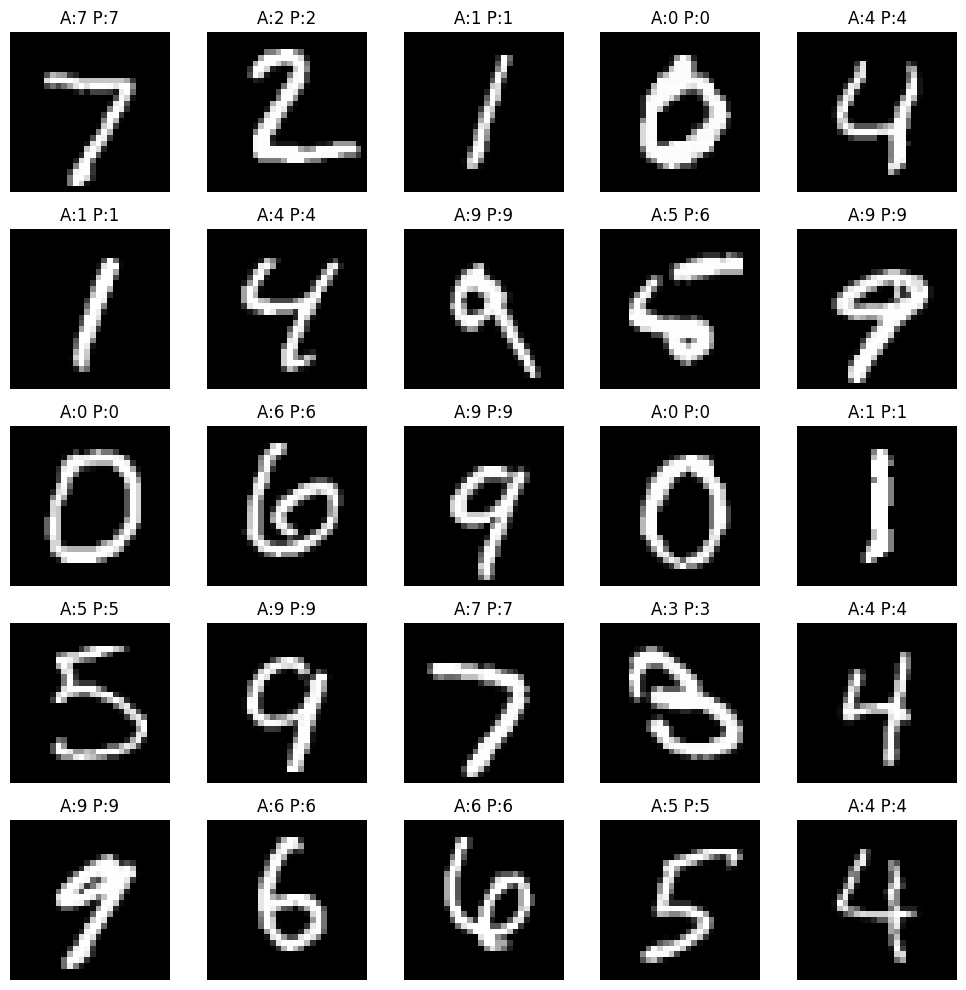

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Grab a batch from the test loader
images, labels = next(iter(test_loader))

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# Plot 25 images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i in range(25):
    img = images[i].numpy().squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"A:{labels[i].item()} P:{predicted[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


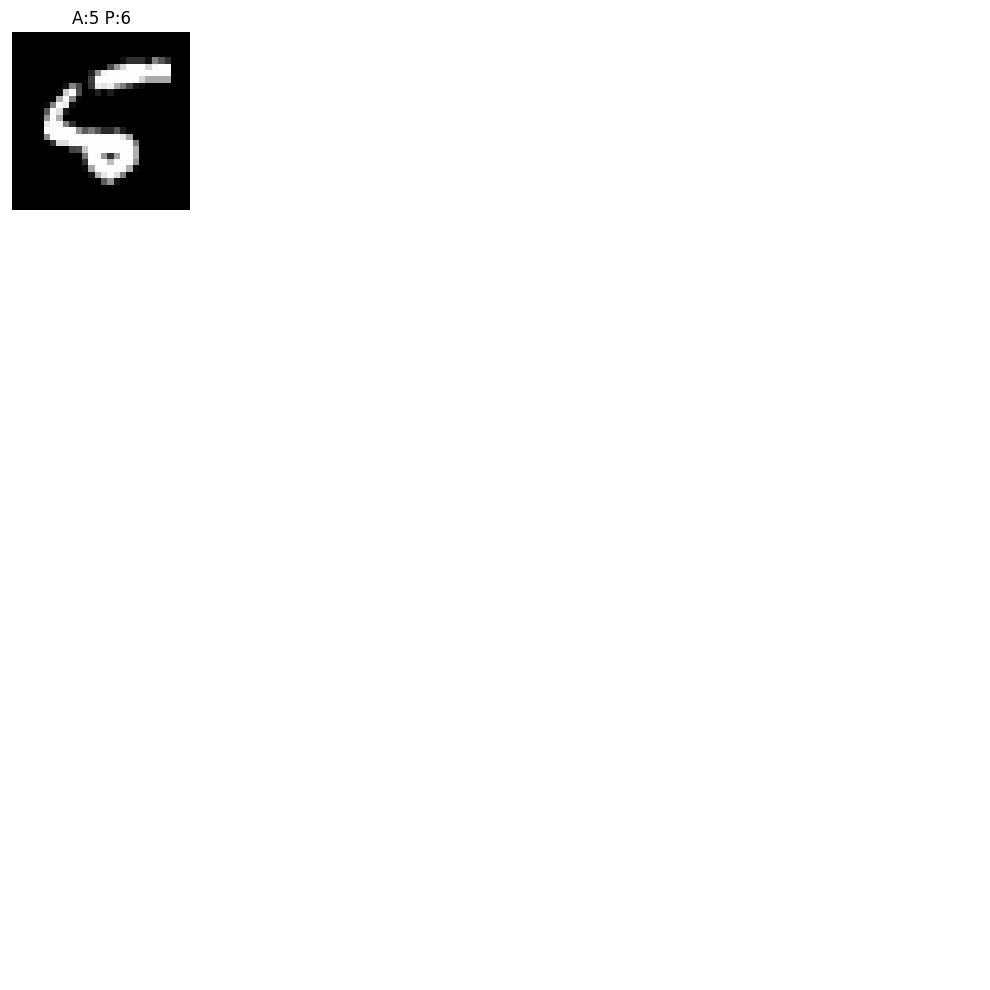

In [29]:
# Find misclassified indices
misclassified_idx = (predicted != labels).nonzero(as_tuple=False).flatten()  # use flatten instead of squeeze

# Limit to 25 images
misclassified_idx = misclassified_idx[:25]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i, idx in enumerate(misclassified_idx):
    img = images[idx].numpy().squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"A:{labels[idx].item()} P:{predicted[idx].item()}")
    axes[i].axis('off')

# Hide any empty subplots
for j in range(len(misclassified_idx), 25):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [30]:
# Create a new instance of the model
model2 = SimpleNN()
# Load saved weights
model2.load_state_dict(torch.load("models/simple_mnist.pth"))
model2.eval()

# Check accuracy again on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Reloaded model accuracy: {100 * correct / total:.2f}%")


Reloaded model accuracy: 96.74%
